# 1. Introduction <a class='anchor' id='intro'></a>

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">1.1 Outline</p>

* In this notebook, we showcase the **Mish activation function** introduced in the 2019 paper [Mish: A Self Regularized Non-Monotonic Activation Function](https://arxiv.org/abs/1908.08681) by Diganta Misra [1].
* We motivate and explain the **mathematical derivations** of Mish as well as compare its **properties** and **performance** to other state-of-the-art activation functions.
* Implementations of Mish are provided in **NumPy**, **TensorFlow** and **Keras**.
* We **replicate two experiments** from the paper, namely an ablation study on MNIST and a benchmark study on CIFAR-10. 
* The code is **commented** and **reusable** so that anyone can easily swap in their own custom activation function and run the same experiments.

### <font color='#17279c'>Table of contents<font><a class='anchor' id='top'></a>
1. [Introduction](#intro)
2. [Activation functions](#activation_functions)
3. [Mish](#mish)
4. [Experiments](#experiments)
5. [Discussion](#discussion)
6. [References](#refs)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">1.2 At a glance</p>

Mish is defined to be

$$
\text{Mish}(x) = x \tanh(\text{softplus}(x))
$$
where $\text{softplus}(x)=\ln(1+e^x)$.

<br>

<center>
<img src='https://i.postimg.cc/Hkw0ccfh/mish-act.png' width=500>
    <figcaption>Mish, image source: S. Cortinhas</figcaption>

<br>
<br>

We will soon dive into all the details but for now just notice how it is elegantly defined in terms of **3 other activation functions** (identity, tanh, softplus).

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">1.3 Libraries</p>

In [1]:
# Core
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', font_scale=1.6, rc={"figure.dpi":250, 'savefig.dpi':250})
from scipy.stats import norm
import time
import random
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from keras.layers.core import Activation
from keras.utils.generic_utils import get_custom_objects

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">1.4 Reproducibility</p>

In [2]:
# Set random seeds
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
set_seed()

# 2. Activation functions <a class='anchor' id='activation_functions'></a> [↑](#top)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">2.1 History and Motivation</p>

<center>
<img src='https://i.postimg.cc/CKJ3BZ4s/IMG-37-AD5-CA7-CEDF-1.jpg' width=700>
<figcaption>History of activation functions, image source: S. Cortinhas</figcaption>
    
<br>
<br>

Activation functions were originally **inspired by the neurons in the brain** and date back to the early 1970s [2]. The idea was to decide whether a neuron should be **activated** or not, **mimicking the behaviour of a synapse** (the small gap between two neurons). Popular functions used to produce this behaviour at the time were sigmoid, tanh and ReLU [2]. 

Due to lack of computational power, research on machine learning and neural networks slowed down significantly for many years. It was not until the **2010's** that neural networks really took off again with the development of **backpropagation on GPUs** [9]. Nowadays, we think of activation functions as being **real-valued pointwise functions** used to provide the necessary **non-linearity** to learn complex tasks. The most well-known examples in the last decade include Softplus [8], LeakyReLU [3], PReLU [5], ELU [4], GELU [6], Swish [7] and Mish [1]. 
    


## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">2.2 Examples</p>

The earliest activation functions used were **sigmoid** and **tanh**. These produce smooth **S curves** and are defined in terms of a ratio of exponentials.

$$
\text{sigmoid}(x) = \frac{1}{1+e^{-x}}
$$
<br>
$$
\text{tanh}(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}}
$$

The main drawbacks to sigmoid and tanh are that they have a **vanishing gradient** problem. In particular, when $|x|$ is large the functions flatten out resulting in **gradients that are close to 0**. This significantly **slows down** the ability for a model to learn the right parameters, especially for deep neural networks. 

<br>
<hr>
<br>

Next came the **Rectified Linear Unit** (ReLU), which doesn't suffer from the vanishing gradient problem for positive inputs. This is a simple and very effective **non-smooth** activation function that is still widely used today.

<br>
$$
\text{ReLU}(x) = \begin{cases}
x, \qquad \text{if} \, x>0,\\
0, \qquad \text{otherwise}.
\end{cases}
$$
<br>

Although very fast, ReLU does suffer from the **dying neuron** problem, where neurons with negative inputs get **switched off** (set to 0) and struggle to get switched back on. 

<br>
<hr>
<br>

The dying neuron problem is what most subsequent activation functions try to resolve. For example, **softplus** is a smooth approximation to Relu that is never equal to 0. A drawback however, is that it is **more computationally expensive** than using ReLU. 

<br>
$$
\text{Softplus}(x) = \ln(1+e^x)
$$

<br>
<hr>
<br>

Next came **LeakyReLU** and **Parametric ReLU** (PReLU), which aimed to tackle the dying neuron problem whilst still being computationally effecient. They both add a **slight slope** for negative inputs so that the **gradient in this region is positive**. LeakyReLU does this by assigning the slope to be a **fixed number** like 0.01 or 0.05, whereas PReLU makes this a **trainable parameter** in the model. 

$$
\text{LeakyReLU}(x) = \begin{cases}
x, \qquad \quad \,\,\, \text{if} \, x>0,\\
0.01x, \qquad \text{otherwise}.
\end{cases}
$$
<br>
$$
\text{PReLU}(x) = \begin{cases}
x, \qquad \,\,\, \text{if} \, x>0,\\
ax, \qquad \text{otherwise}.
\end{cases}
$$

<br>
<hr>
<br>

The **Exponential Linear Unit** (ELU) works in a similar way to PReLU with a hyper-parameter $a$ but aims to get the mean activations closer to zero on average. This can speed up the learning process for deep neural networks and has been shown to result in more accurate models than ReLU [4].

<br>
$$
\text{ELU}(x) = \begin{cases}
x, \qquad \qquad \quad \text{if} \, x>0,\\
a(e^x-1), \qquad \text{otherwise}.
\end{cases}
$$

<br>
<hr>
<br>

The **Gaussian-Error Linear Unit** (GELU) is another **smooth approximation** to ReLU that uses the cumulative distribution function (CDF) of the standard normal distribution, denoted $\Phi(x)$. It has the interesting feature of a **bump** around 0, making it in some sense **more non-linear** than previous activation functions. It has been used in large language models like BERT [6].

<br>
$$
\text{GELU}(x) = x \cdot \Phi(x)
$$

<br>
<hr>
<br>

Our last example is **swish**, similar to GeLU in that it is both **smooth and non-monotonic** although it is **less computationally expensive**. It has been shown to lead to more accurate models than ReLU [7].

$$
\text{swish}(x) = x \cdot \text{sigmoid}(x)
$$

In [3]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def tanh(x):
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def relu(x):
    return np.maximum(0,x)

def softplus(x):
    return np.log(1+np.exp(x))

def leakyrelu(x):
    return np.maximum(0.01*x,x)

def prelu(x,a=0.05):
    return np.maximum(a*x,x)

def elu(x,a=1):
    return x*(x>0) + a*(np.exp(x)-1)*(x<0)

def gelu(x):
    return x*norm.cdf(x)

def swish(x):
    return x*sigmoid(x)

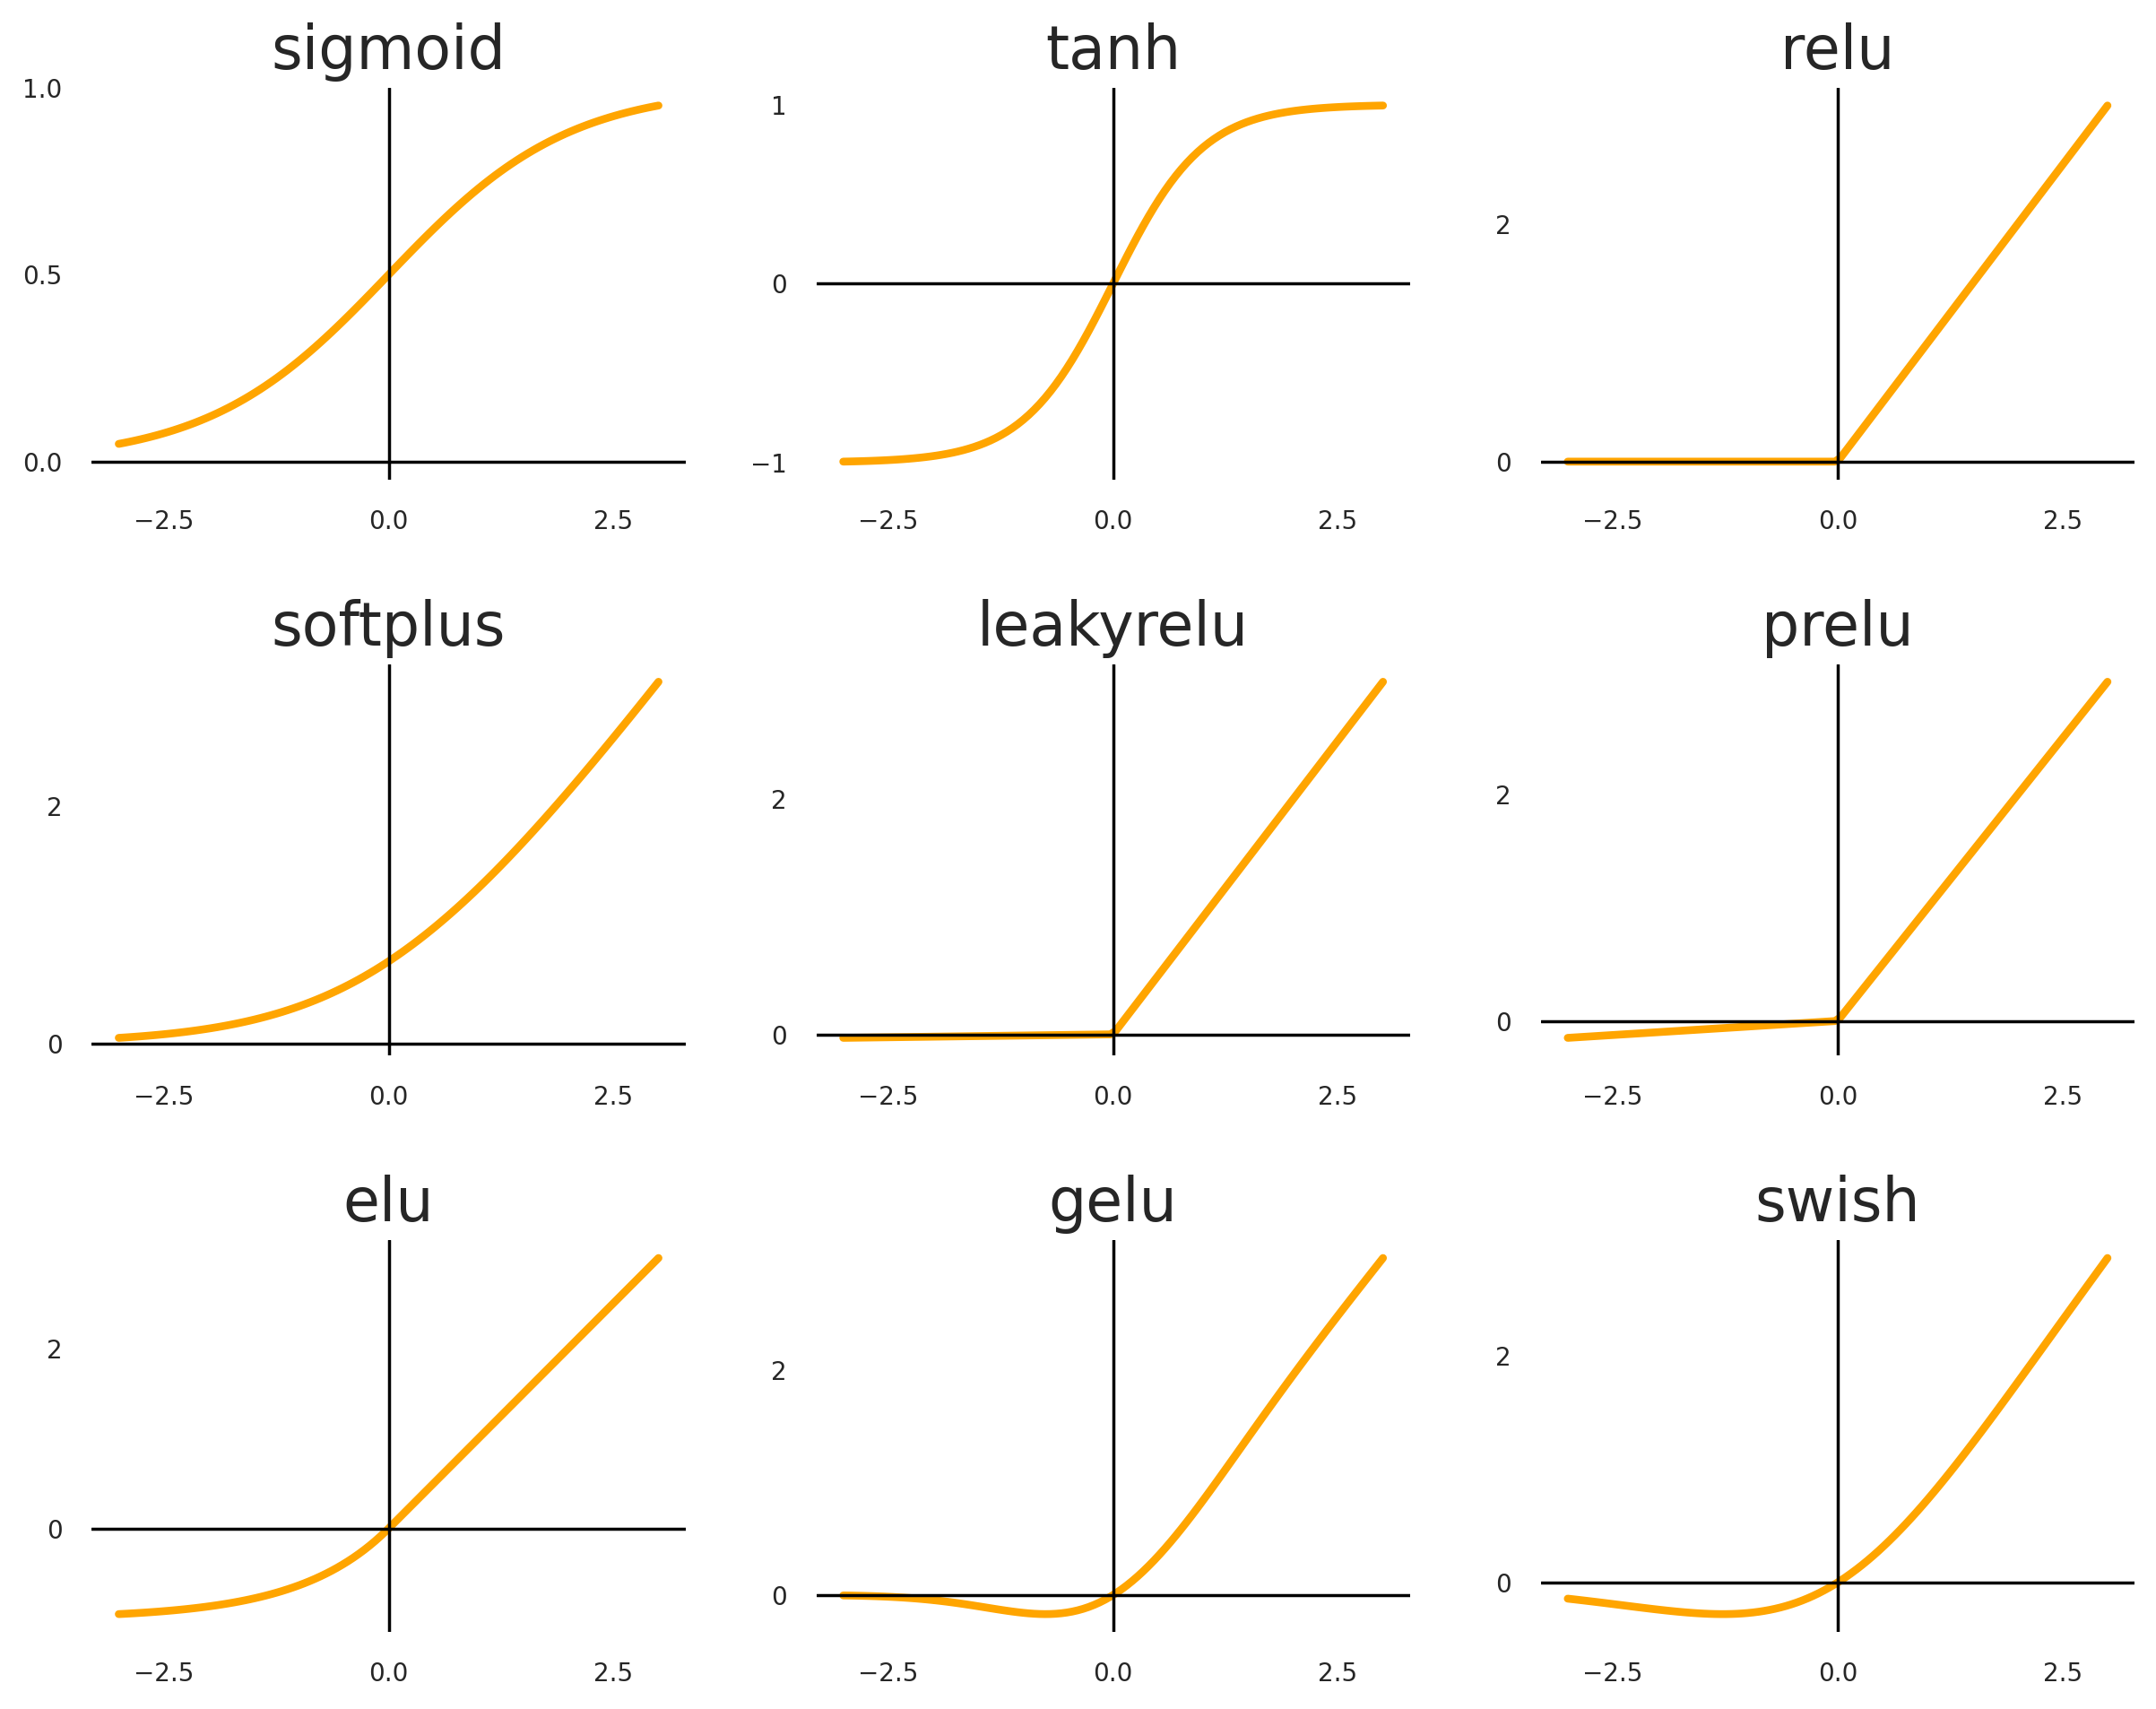

In [4]:
# Grid
xx = np.linspace(start=-3,stop=3,num=100)

# Plot activation functions
plt.figure(figsize=(10,8))
for i, act in enumerate([sigmoid,tanh,relu,softplus,leakyrelu,prelu,elu,gelu,swish]):
    plt.subplot(3,3,i+1)
    plt.plot(xx,act(xx), color='orange', linewidth=2.5)
    plt.axhline(color='black', linewidth=1)
    plt.axvline(color='black', linewidth=1)
    plt.title(act.__name__)
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# Aesthetics
plt.tight_layout()
sns.despine(bottom=True,left=True)
plt.show()

# 3. Mish <a class='anchor' id='mish'></a> [↑](#top)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">3.1 Motivation</p>

$$
\text{Mish}(x) = x \tanh(\text{softplus}(x))
$$
<br>

The discovery of Mish was inpired by Swish and "was found by systematic analysis and experimentation over the characteristics that made Swish so effective" [1]. In particular, those characteristics being a **smooth non-monotonic curve**, which we have discussed results in **better information propagation** compared to ReLU. 

In the development of Mish, several other activation functions were considered. Those being $\arctan(x) \text{softplus}(x)$, $\text{tanh}(x)\text{softplus}(x)$, $x \log(1+\arctan(e^x))$ and $x\log(1+\text{tanh}(e^x))$. In my experience, it is rare for a research author to reveal the things that **didn't work** for them so I feel the need to applaud this level of transparency. 

<br>
<center>
<img src='https://i.postimg.cc/sDtDCVMy/swishmish.png' width=650>
<figcaption>(a) Graph of Mish, Swish, and similar validated experimental functions. (b) Training curve of a six-layered CNN on CIFAR-10 on different validated activation functions, image source: [1]</figcaption>
<br>
<br>

Although $x\log(1+\text{tanh}(e^x))$ performed at a similar level to Mish in these preliminary results, it was later found to be much less stable in a variety of deep learning architectures. 

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">3.2 Properties</p>

## Smooth

The mathematical definition of 'smoothness' is a stronger one than continuity. A function is smooth if it is **infinitely differentiable**, which heuristically translates to there being no jumps or sharp edges. This is a useful property because it means we can calculate gradients to any order and it generally leads to **more stable** optimisation problems. 

We can see that $\text{Mish}(x)=x\text{tanh}(\text{softplus}(x))$ is smooth using the fact that products and compositions of smooth functions are themselves smooth. 

## Non-monotonic

A non-monotonic function is one that can go up and down, i.e. it is not monotonically increasing and not monotonically decreasing. Historically, most activation functions have been monotonic (sigmoid, tanh, ReLU, etc), however more recently non-monotonic have proven to be very effective. You can intuitively think of these as being **more non-linear** than monotonic functions.

<br>
<center>
<img src='https://miro.medium.com/max/1400/1*9-V2iljnY1aM6OgVxHneVg.png' width=600>
<figcaption>Examples of monotonic and non-monotonic functions, image source: [10]</figcaption>
<br>
<br>

Mish is clearly non-monotonic by looking at its graph (see section 1.2).

## Bounded below
    
A function that is bounded below is one that has a **lowest point**, i.e. does not tend to minus infinity. This property is conventional among activation functions as it was developed from the idea of a neuron being **turned off**.

Numerically, the range of Mish is estimated to be $(-0.31, \infty)$ so it is bounded below.

## Unbounded above

A function that is unbounded above is one that has **no highest point**, i.e. tends to positive infinity. This property is by no means required (e.g. consider sigmoid, tanh) but tends to result in a faster convergence of model parameters. 

Mish is unbounded above since $\ln(1+e^x) \sim x$ for large x and $\text{tanh}(x) \rightarrow 1$ as $x \rightarrow \infty$, hence

$$
\lim_{x\rightarrow \infty} \text{Mish}(x) = \infty
$$

## Self-regularizing

The self-regularizing property of Mish relates to its derivative, which we will calculate and discuss shortly. In essense, it means that Mish results in optimisation functions which are **easier to minimise** and are **more robust** to changes in network architecture and hyperparameters. This effect is more pronounced for very deep neural networks as we will show in the experiments section.

<br>
<br>

<center>
<img src='https://i.postimg.cc/yxQGmzFG/mish-ll.png' width=650>
<figcaption>Comparison between the loss landscapes of (from left to right): (a) ReLU, (b) Mish
and (c) Swish activation function for a ResNet-20 trained for 200 epochs on CIFAR-10, image source: [1]</figcaption>

<br>
<br>
    
In this figure, the loss landscape of Mish is smoother and has a "wider minima which improves generalization compared to that of ReLU and Swish, with the former having multiple local minimas" [1].

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">3.3 Derivatives</p>

The paper presents the following equation for the derivative of Mish.

$$
\text{Mish}'(x) = \frac{\text{Mish}(x)}{x} + \text{swish}(x) \Delta(x)
$$

Let's try to derive this for ourselves.

<br>
<hr>
<br>

To calculate the derivative of Mish, we will need to use the product rule and the chain rule, so let's recap them first.

**Product rule**

$$
\frac{d}{dx} [f(x) g(x)] = f'(x) g(x) + f(x) g'(x)
$$

**Chain rule**

$$
\frac{d}{dx} [f(g(x))] = f'(g(x)) g'(x)
$$

<br>
<hr>
<br>

Now for the derivation of the **derivative of Mish**. Recall that Mish is defined as 

$$
\text{Mish}(x) = x \tanh(\text{softplus}(x))
$$
where $\text{softplus}(x)=\ln(1+e^x)$.

<br>

**Step 1:** Apply the product rule with $f(x)=x$ and $g(x)=\tanh(\text{softplus}(x))$. This gives us

$$
\text{Mish}'(x) = \tanh(\text{softplus}(x)) + x \left(\frac{d}{dx} \tanh(\text{softplus}(x)) \right)
$$

<br>


**Step 2:** Apply the chain rule to the remaining derivative with $f(x)=\tanh(x)$ and $g(x)=\text{softplus}(x)$. This yields

$$
\text{Mish}'(x) = \tanh(\text{softplus}(x)) + x \left(\text{sech}^2(\text{softplus}(x)) \frac{d}{dx} \text{softplus}(x) \right)
$$

where we used the standard result that $\frac{d}{dx}\tanh(x)=\text{sech}^2(x)$.

<br>

**Step 3:** Evaluate the derivate of $\text{softplus}(x)=\ln(1+e^x)$ using the chain rule with $f(x)=\ln(x)$ and $g(x)=1+e^x$. We end up with

$$
\text{Mish}'(x) = \tanh(\text{softplus}(x)) + x \left(\text{sech}^2(\text{softplus}(x)) \frac{e^x}{1+e^x}\right)
$$

where we used the fact that $\frac{d}{dx}\ln(x)=\frac{1}{x}$.

<br>

**Step 4:** Finally, we use some tricks and re-arrange. Observe that the first term is the same as 

$$
\tanh(\text{softplus}(x)) = \frac{x}{x} \tanh(\text{softplus}(x)) = \frac{\text{Mish}(x)}{x}
$$

and that the ratio of exponentials is

$$
\frac{e^x}{1+e^x} = \frac{1}{1+e^{-x}} = \text{sigmoid}(x).
$$

<br>

**Putting the pieces together** and using the definition of $\text{swish}(x)=x \cdot \text{sigmoid}(x)$ gives us

$$
\text{Mish}'(x) = \frac{\text{Mish}(x)}{x} + \text{swish}(x) \Delta(x)
$$

where $\Delta(x)=\text{sech}^2(\text{softplus}(x))$, as desired.

<br>
<br>

<center>
<img src='https://i.postimg.cc/3R1FPCb5/mish-derivatives.png' width=700>
<figcaption>(a) Graph of Mish, ReLU, SoftPlus, and Swish activation functions. As illustrated,
Mish and Swish are closely related with both having a distinctive negative concavity unlike ReLU, which accounts for preservation of small negative weights. (b) The 1st and 2nd
derivatives of Mish and Swish activation functions, image source: [1]</figcaption>

<br>
<br>
    
As we can see, Swish and Mish are **closely related**. Both functions **lie close to each other** and likewise for their derivatives. It is interesting to see that Swish actually appears in the first derivative of Mish. 
    
The author of the Mish paper speculates that "the $\Delta(x)$ parameter acts like a preconditioner, making the **gradient smoother**" and calls for more research to be done to uncover whether this is true or not [1]. This regularizing effect could be the reason why Mish leads to an **easier to optimise objective function** and thus outperforms Swish "in **increasingly deep** and complex neural net architectures".

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">3.4 Implementations</p>

We provide implementations of Mish in **NumPy**, **TensorFlow** and **Keras**.

<br>

### NumPy

In [5]:
# Mish from scratch
def mish(x):
    '''
    Mish activation function: Mish(x) = x*tanh(softplus(x)) = x*tanh(ln(1+e^x))
    
    Implementated with numpy.
    
    Parameters
    ----------
    x : array_like. Array of shape (n_samples,)
    
    Returns
    -------
    Mish(x) : ndarray. Result of shape (n_samples,)
    
    Example
    -------
    >>> x = [1,2,3]
    >>> z = mish(x)
    array([0.86509839, 1.94395896, 2.986535])
    '''
    return x*np.tanh(np.log(1+np.exp(x)))

# Example
x = [1,2,3]
mish([-5,2,4])

array([-0.03357624,  1.94395896,  3.99741281])

### TensorFlow

In [6]:
# Mish in TensorFlow
def mish_tf(x):
    '''
    Mish activation function: Mish(x) = x*tanh(softplus(x)) = x*tanh(ln(1+e^x))
    
    Implementated with TensorFlow.
    
    Parameters
    ----------
    x : tf.Tensor. Tensor of shape (n_samples,)
    
    Returns
    -------
    Mish(x) : tf.Tensor. Result of shape (n_samples,)
    
    Example
    -------
    >>> x = tf.convert_to_tensor([1,2,3], dtype=tf.float32)
    >>> z = mish_tf(x)
    <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.8650984, 1.943959 , 2.9865355], dtype=float32)>
    '''
    return x*tf.math.tanh(tf.math.softplus(x))

# Example
x = tf.convert_to_tensor([-5,2,4], dtype=tf.float32)
mish_tf(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.03357624,  1.943959  ,  3.9974127 ], dtype=float32)>

### Keras

In [7]:
# Mish using Keras backend
def mish_ke(x):
    '''
    Mish activation function: Mish(x) = x*tanh(softplus(x)) = x*tanh(ln(1+e^x))
    
    Implementated with Keras.
    
    Parameters
    ----------
    x : tf.Tensor. Tensor of shape (n_samples,)
    
    Returns
    -------
    Mish(x) : tf.Tensor. Result of shape (n_samples,)
    
    Example
    -------
    >>> x = tf.convert_to_tensor([1,2,3], dtype=tf.float32)
    >>> z = mish_ke(x)
    <tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.8650984, 1.943959 , 2.9865355], dtype=float32)>
    '''
    return x*K.tanh(K.softplus(x))

# Example
x = tf.convert_to_tensor([-5,2,4], dtype=tf.float32)
mish_ke(x)

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([-0.03357624,  1.943959  ,  3.9974127 ], dtype=float32)>

The following line of code is used to **connect our custom activation function to keras**.

In [8]:
# Make our custom activation function compatible with keras
get_custom_objects().update({'mish_ke': Activation(mish_ke)})

# 4. Experiments <a class='anchor' id='experiments'></a> [↑](#top)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">4.1 Ablation study on MNIST</p>

One of the key findings of the Mish paper is that it allows you to train **deeper** neural networks (more hidden layers) with less performance degradation compared to ReLU and Swish. We will try to replicate this result in this section.


<br>
<center>
<img src='https://i.postimg.cc/tJDXmCDb/ablation.png' width=350>
<figcaption> Comparison between Mish, Swish, and ReLU activation functions in terms
of test accuracy with increasing depth of the neural network on the MNIST dataset, image source: [1]</figcaption>

<br>
<br>

The idea is to compare different activation functions on the same task, with the same neural network and hyperparameters. Just like in the paper, we will use the **MNIST digit classification dataset** and fully connected neural networks of linearly
increasing depth. The width of each layer is **500 neurons**. **Batch normalisation** and **dropout** with a **rate of 25%** is used along with the **stochatic gradient descent** (SGD) optimiser and a **batch size of 128**. A fixed **learning rate of 0.01** is used for **40 epochs**.

In [9]:
# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Normalise and reshape arrays
X_train, X_test = X_train.reshape((-1, 784))/255.0, X_test.reshape((-1, 784))/255.0

# Print shapes
X_train.shape, X_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 784), (10000, 784))

In [10]:
# Feed-forward neural network using keras
def build_mnist_model(depth=15, activation='mish_ke'):  
    # Sequential model
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(784,)))
    
    # Hidden layers
    for i in range(depth-1):
        model.add(layers.Dense(units=500))
        model.add(layers.BatchNormalization())
        model.add(layers.Activation(activation))
        model.add(layers.Dropout(rate=0.25))
    
    # Output layer
    model.add(layers.Dense(units=10, activation='softmax'))
    
    # Compile model
    model.compile(optimizer='SGD',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
    
    return model

The following code works for **any number** of activations and any range of depths. Feel free to run your own experiments - all you have to change are the two variables `activations` and `depths`.

In [11]:
# Variables
activations = ['mish_ke','swish','relu']
depths = range(15,26)

# Test accuracies
test_acc=[]

# Grid search over activations and depth
for activation in activations:
    for depth in depths:
        # Start timer
        start=time.time()
        
        # Build model
        model = build_mnist_model(depth,activation)

        # Train model
        history = model.fit(
            X_train, y_train,
            batch_size=128,
            epochs=40,
            verbose=False
        )
        
        # Evaluate model
        test_acc.append(100*model.evaluate(X_test,y_test,verbose=False)[1])
        
        # Stop timer
        stop=time.time()
        
        # Print iteration
        print(f'Activation: {activation}, Depth: {depth}, Accuracy: {test_acc[-1]:.2f} %, Time: {(stop-start)/60:.2f} mins')
        
print('Training complete!')

Activation: mish_ke, Depth: 15, Accuracy: 97.82 %, Time: 3.22 mins
Activation: mish_ke, Depth: 16, Accuracy: 97.74 %, Time: 3.34 mins
Activation: mish_ke, Depth: 17, Accuracy: 97.80 %, Time: 3.53 mins
Activation: mish_ke, Depth: 18, Accuracy: 97.62 %, Time: 3.75 mins
Activation: mish_ke, Depth: 19, Accuracy: 97.54 %, Time: 3.90 mins
Activation: mish_ke, Depth: 20, Accuracy: 97.49 %, Time: 4.20 mins
Activation: mish_ke, Depth: 21, Accuracy: 97.31 %, Time: 4.43 mins
Activation: mish_ke, Depth: 22, Accuracy: 97.42 %, Time: 4.57 mins
Activation: mish_ke, Depth: 23, Accuracy: 97.27 %, Time: 4.89 mins
Activation: mish_ke, Depth: 24, Accuracy: 97.33 %, Time: 4.99 mins
Activation: mish_ke, Depth: 25, Accuracy: 96.75 %, Time: 5.22 mins
Activation: swish, Depth: 15, Accuracy: 97.68 %, Time: 3.11 mins
Activation: swish, Depth: 16, Accuracy: 97.64 %, Time: 3.33 mins
Activation: swish, Depth: 17, Accuracy: 97.71 %, Time: 3.50 mins
Activation: swish, Depth: 18, Accuracy: 97.61 %, Time: 3.68 mins
Act

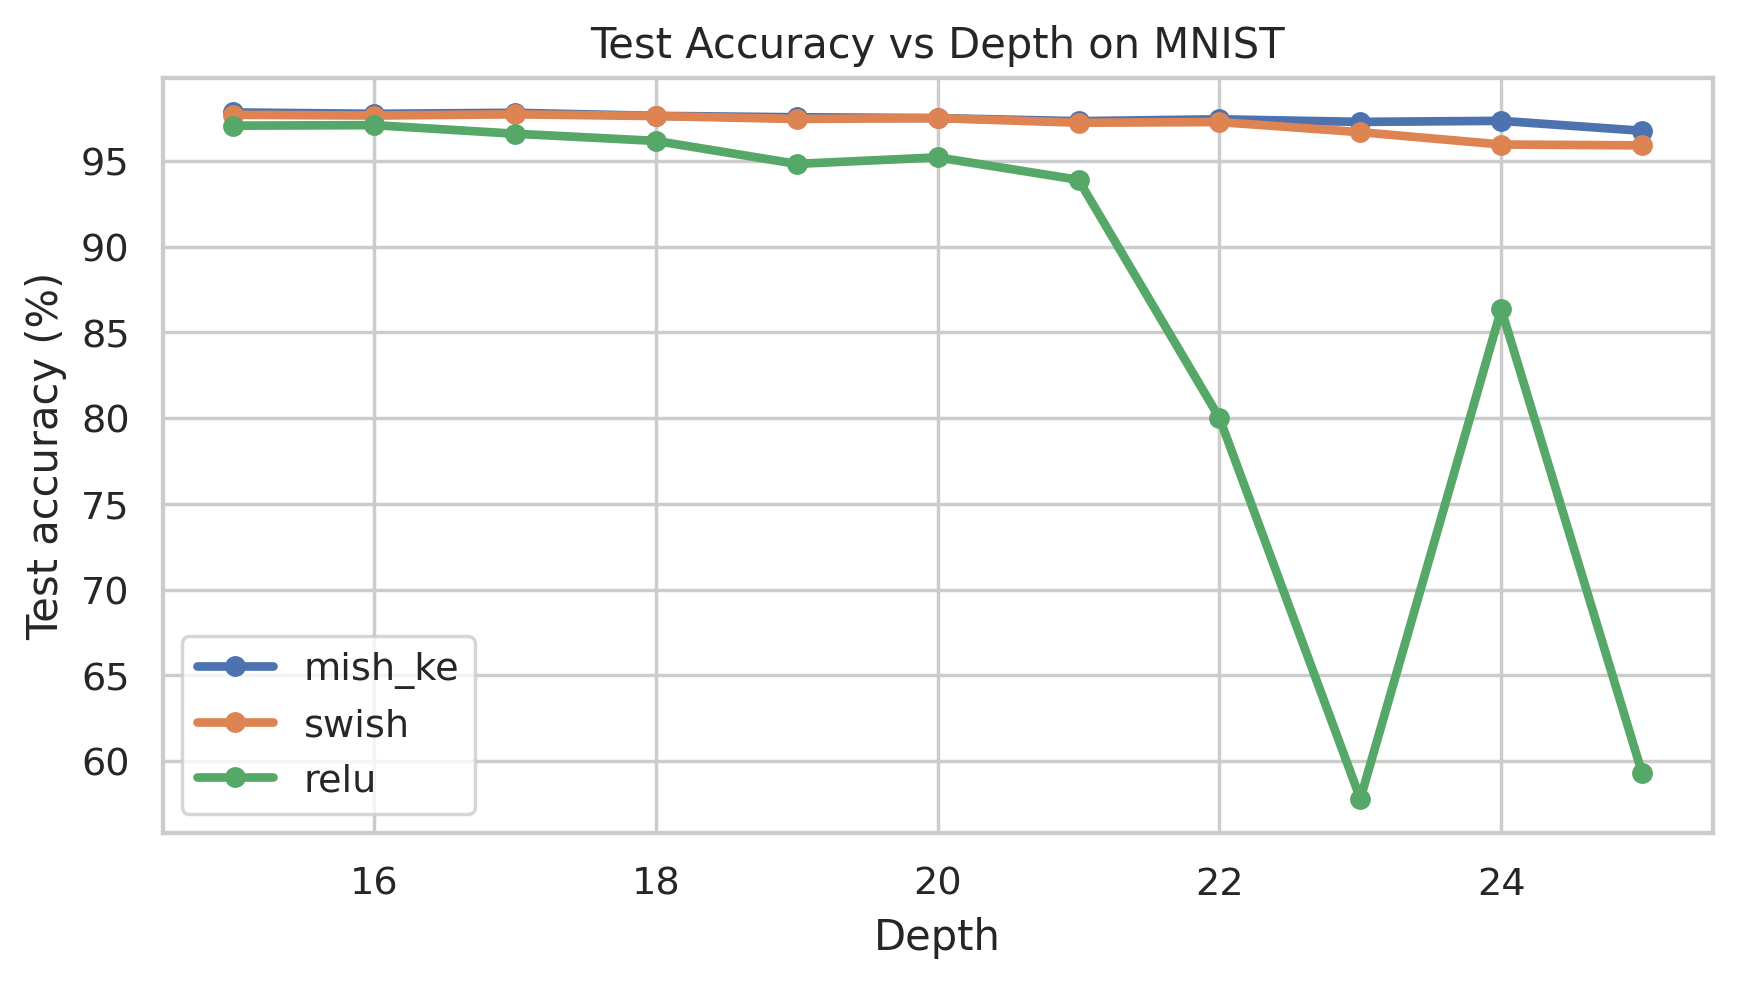

In [12]:
# New figure
sns.set(style='whitegrid', font_scale=1, rc={"figure.dpi":250, 'savefig.dpi':250})
plt.figure(figsize=(8,4))

# Plot test accuracy for each activation
for i, activation in enumerate(activations):
    plt.plot(depths,test_acc[i*len(test_acc)//len(activations):(i+1)*len(test_acc)//len(activations)],label=activation,marker='.',linewidth=2.5,markersize=10)

# Aesthetics
plt.title('Test Accuracy vs Depth on MNIST')
plt.xlabel('Depth')
plt.ylabel('Test accuracy (%)')
plt.legend()
plt.show()

These results match with the ones from the paper quite well. Using Mish consistently produces higher test accuracies for deeper neural networks compared to swish and especially ReLU. 

I suspect we achieve higher accuracies across the board compared to the paper because we train for longer than they do (the number of epochs wasn't specified).

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">4.2 Benchmarks on CIFAR-10</p>

The Mish paper also compared Mish to other state-of-the-art activation functions on the **CIFAR-10 image classification dataset** using state-of-the-art neural networks. It was found that "Mish consistently matched or exceeded the best performing network".

<br>
<center>
<img src='https://i.postimg.cc/DZYZmvJB/stat-results.png' width=350>
<figcaption> Statistical results of different activation functions on image classification of CIFAR10 dataset using a Squeeze Net for 23 runs, image source: [1]</figcaption>

<br>
<br>
    
Due to computational limits, instead of using SqueezeNet we will use a smaller **6-layered convolutional neural network** (CNN) to run the experiment. But just like in the paper we will train this model with the **Adam optimiser** for **50 epochs** and a different activation function each time. 

In [13]:
# Load CIFAR-10 dataset
(X_train2, y_train2), (X_test2, y_test2) = tf.keras.datasets.cifar10.load_data()

# Normalize arrays
X_train2, X_test2 = X_train2/255.0, X_test2/255.0

# Print shapes
X_train2.shape, X_test2.shape

170508288/170498071 [==============================] - 6s 0us/step


((50000, 32, 32, 3), (10000, 32, 32, 3))

In [14]:
# 6-layer CNN using keras
def build_cifar10_model(activation='relu'):
    # Keras sequential model
    model = keras.Sequential([
        # Convolutional layer 1
        layers.Conv2D(filters=32, kernel_size=5, strides=1, padding='same', input_shape=[32,32,3], activation=activation),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        layers.Dropout(rate=0.25),

        # Convolutional layer 2
        layers.Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation=activation),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        layers.Dropout(rate=0.25),
        
        # Convolutional layer 3
        layers.Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation=activation),
        layers.MaxPool2D(pool_size=2, padding='valid'),
        layers.Dropout(rate=0.25),
        layers.Flatten(),
        
        # Dense layer 4
        layers.Dense(units=128, activation=activation),
        layers.Dropout(rate=0.25),
        
        # Dense layer 5
        layers.Dense(units=128, activation=activation),
        layers.Dropout(rate=0.25),

        # Output layer 6 (softmax returns a probability distribution)
        layers.Dense(units=10, activation='softmax')
    ])
    
    # Compile model
    model.compile(optimizer='Adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
    
    return model

Feel free to run this experiment yourself. You can change the list of activation functions in `act_list` or alter the neural network architecture above.

In [15]:
# List of activations to evaluate
act_list = ['mish_ke','swish','gelu','relu','elu','selu','softplus','tanh','sigmoid']

# Test accuracies
test_acc2=[]

# Evaluate each activation
for act in act_list:
    # Start timer
    start=time.time()
    
    # Build model
    model = build_cifar10_model(activation=act)

    # Train model
    history = model.fit(
        X_train2, y_train2,
        batch_size=128,
        epochs=50,
        verbose=False
    )
    
    # Evaluate model
    test_acc2.append(100*model.evaluate(X_test2,y_test2,verbose=False)[1])
    
    # Stop timer
    stop=time.time()
    
    # Print iteration
    print(f'Activation: {act}, Accuracy: {test_acc2[-1]:.2f} %, Time: {(stop-start)/60:.2f} mins')
    
print('Training complete!')

Activation: mish_ke, Accuracy: 78.47 %, Time: 1.88 mins
Activation: swish, Accuracy: 78.66 %, Time: 1.67 mins
Activation: gelu, Accuracy: 78.66 %, Time: 2.14 mins
Activation: relu, Accuracy: 79.39 %, Time: 1.32 mins
Activation: elu, Accuracy: 78.61 %, Time: 1.40 mins
Activation: selu, Accuracy: 77.86 %, Time: 1.42 mins
Activation: softplus, Accuracy: 71.05 %, Time: 1.47 mins
Activation: tanh, Accuracy: 74.75 %, Time: 1.41 mins
Activation: sigmoid, Accuracy: 67.41 %, Time: 1.40 mins
Training complete!


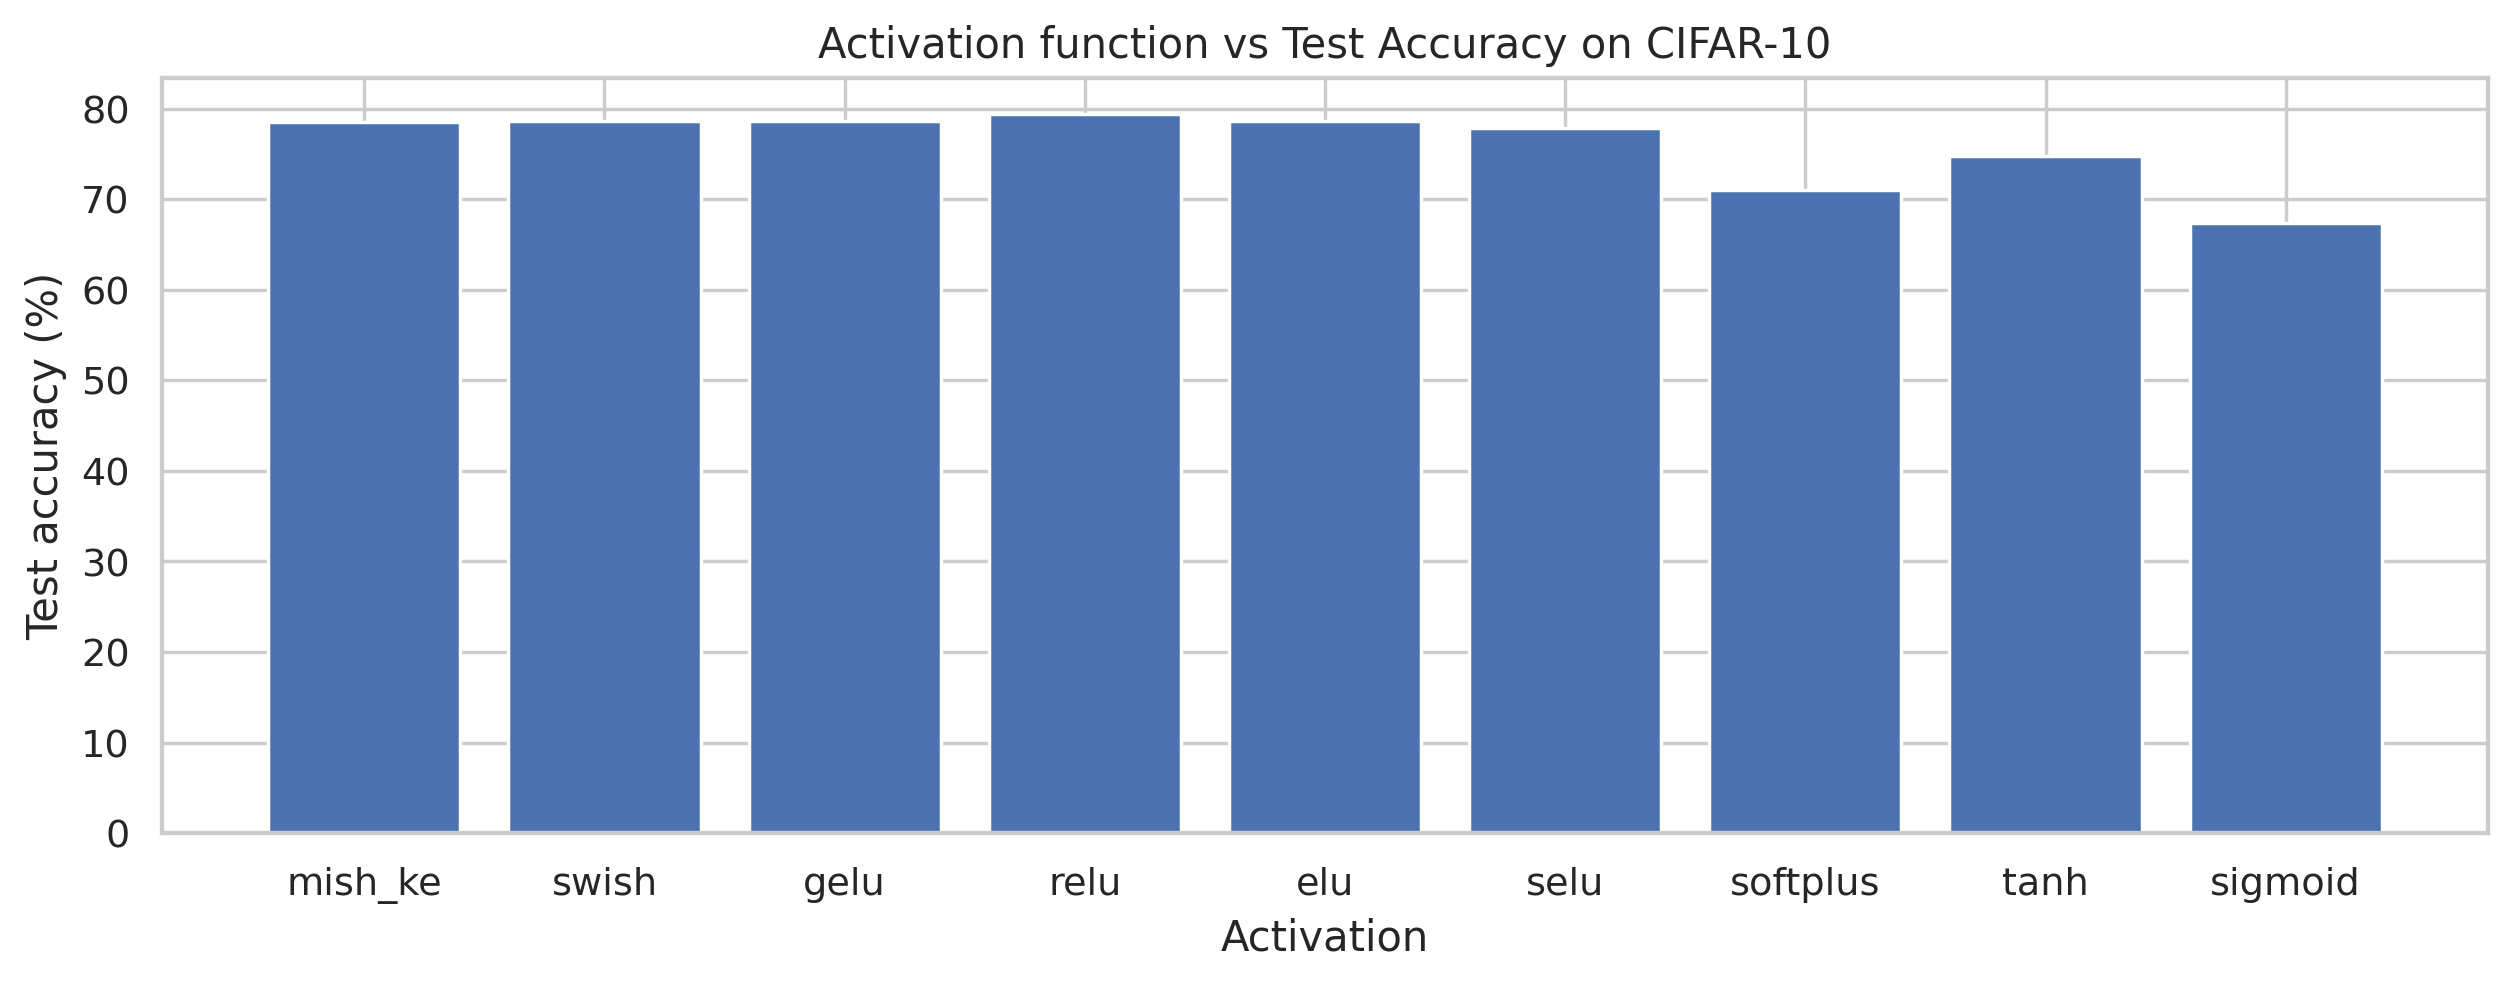

In [16]:
# Plot results with barchart
plt.figure(figsize=(12,4))
plt.bar(act_list,test_acc2)

# Aesthetics
plt.title('Activation function vs Test Accuracy on CIFAR-10')
plt.xlabel('Activation')
plt.ylabel('Test accuracy (%)')
plt.show()

This experiment shows that Mish is competitive with other state-of-the-art activation functions when used in a small CNN on the CIFAR-10 dataset. 

# 5. Discussion <a class='anchor' id='discussion'></a> [↑](#top)

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">5.1 Other results from the paper</p>

The paper also validated Mish on other datasets like **ImageNet-1k** and **MS-COCO**. Mish was shown to consistently outperform other activation functions with, in particular, a "1% increase in Top-1 Accuracy over Leaky ReLU in CSP-ResNet-50 architecture." Whilst this may not seem like a lot, it is **very significant** when using state-of-the-art neural networks where marginal improvements are difficult to achieve.

<br>
<center>
<img src='https://i.postimg.cc/1XPPBtgm/image1k.png' width=600>
<figcaption> Comparison between Mish, Swish, ReLU and Leaky ReLU activation functions
on image classification of ImageNet-1k dataset across various standard architectures. Data
Augmentation indicates the use of CutMix, Mosaic, and Label Smoothing. † indicate scores for ReLU, image source: [1]</figcaption>

<br>
<br>

The most obvious **drawback** of Mish is its **computational complexity** compared to other activation functions. The Mish paper recognises there is a "trade-off between the increase in accuracy while using Mish and the increase in computational cost". It addresses this by proposing a CUDA-based implementation in PyTorch, which can significantly speed up Mish. 
    
<br>
<center>
<img src='https://i.postimg.cc/cJ1MPqjd/mishtime.png' width=500>
<figcaption> Comparison between the runtime for the forward and backward passes for ReLU,
SoftPlus, Mish and Mish-CUDA activation functions for floating point-16 and floating point32 data, image source: [1]</figcaption>

<br>
<br>
    
The author suggests Mish-CUDA can be further optimised and calls for more research on this topic.

## <p style="font-family:JetBrains Mono; font-weight:normal; letter-spacing: 1px; color:#17279c; font-size:100%; text-align:left;padding: 0px; border-bottom: 3px solid #17279c;">5.2 Conclusion</p>

In this notebook, we have seen that Mish is the **latest milestone** in the field of activation function research. It **matches or improves** the performance of other state-of-the-art activation functions, especially in **increasingly deeper** neural networks as was shown in the experiments section. 

The main reason for its improved performance is believed to be its **self-regularizing property** relating to the $\Delta(x)$ term in its first derivative. This is one area that the author recognises that more theoretical research needs to be done to "understand the underlying mechanism on how [$\Delta(x)$] may be acting as a regularizer".

# 6. References <a class='anchor' id='refs'></a> [↑](#top)

* [1] [Mish: A Self Regularized Non-Monotonic Activation Function](https://arxiv.org/abs/1908.08681)
* [2] [Cognitron: A self-organizing multilayered neural network](https://link.springer.com/article/10.1007/BF00342633)
* [3] [Rectifier Nonlinearities Improve Neural Network Acoustic Models](https://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf)
* [4] [Fast and Accurate Deep Network Learning by Exponential Linear Units (ELUs)](https://arxiv.org/abs/1511.07289)
* [5] [Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification](https://arxiv.org/abs/1502.01852)
* [6] [Gaussian Error Linear Units (GELUs)](https://arxiv.org/abs/1606.08415)
* [7] [Swish: a Self-Gated Activation Function](https://arxiv.org/abs/1710.05941v1?source=post_page---------------------------)
* [8] [Deep Sparse Rectifier Neural Networks](https://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf)
* [9] [ImageNet Classification with Deep Convolutional
Neural Networks](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)
* [10] [Application of Monotonic Constraints in Machine Learning Models](https://medium.com/analytics-vidhya/application-of-monotonic-constraints-in-machine-learning-models-334564bea616)

**Acknowledgements:**

I would like to thank Alexander Ryzhkov for first introducing me to Mish in his [discussion post](https://www.kaggle.com/competitions/tabular-playground-series-oct-2022/discussion/360084). Furthermore, the following resources were helpful in developing this notebook:

* [Mish - Activation Function](https://www.kaggle.com/code/imokuri/mish-activation-function/notebook)
* [Swish Vs Mish: Latest Activation Functions](https://krutikabapat.github.io/Swish-Vs-Mish-Latest-Activation-Functions/)
* [Activation function](https://en.wikipedia.org/wiki/Activation_function)
* [Rectifier (neural networks)](https://en.wikipedia.org/wiki/Rectifier_(neural_networks))
* [sklearn_doc.py](https://gist.github.com/jakevdp/3808292)
* [Comparison of Sigmoid, Tanh and ReLU Activation Functions](https://www.aitude.com/comparison-of-sigmoid-tanh-and-relu-activation-functions/)